# **Privacy-Preserving Invisible Image Watermarking System**

Invisible image watermarking is a technique to embed watermarking information into an image such that it is inperceptible to the human eye. Other than being inperceptible to human eye, it must be **undetecable**(not easily recoverable by adversary), **tamper-proof**(can't be easily modifed by the adversary) and **robust**(should be recoverable even after disortions).

Most of the invisible watermarking techniques could be broadly classified into 3 categories :-
* **Spatial Domain**:- In these techniques, the watermarking information is directly stored in the pixel values of the image channels(i.e RGB, YCrCb, etc.). The LSB (Least Significant Bit) embedding is one such example.
* **Frequency Domain**:- In these techniques, the watermarking information is stored in the co-efficients after transforming the image using any frequency transformation technique. DCT, DWT and DFT embedding are few such examples.
* **Latent Space**:- Most of the deep-learning based techniques would fall into this category. The idea here is to map an image to a latent space and add watermarking information in that space. RivaGan, LDM, LaWa are few such examples.

It has been shown that spatial domain techniques are not robust to disortions(compression, adding noise) and could be tampered easily by an adversary as they work directly with pixel values. On the other hand, frequency domain and latent space techniques are more robust to disortions because they add watermarking information after transforming the image.

## Overview

In this notebook, we attempt to develop an privacy-preserving invisible image watermarking system. The basic requirements that need to satisfied:-
* The input(image to watermarked) must be encrypted.
* The watermarking information must be string or bytes.
* The watermarking information may or may not be encrypted.

Keeping the above requirements in mind, we have used a FHE scheme(TFHE) to develop our system using the Concrete library. 

### Approach

We have skipped the latent space(deep-learning based) watermarking techniques. We initially started with a frequency-domain technique(DFT-based embedding) but since Concrete library doesn't work well with floating-point numbers, we had to skip it as well. In this notebook we have taken an **spatial domain** approach to watermark an image in a privacy-preserving way. In our approach, we embed the watermarking information in the 4th bit of the pixel value in RGB channel. 

#### Watermarking Approach Details

In this project, we would be using spatial domain technique to embed watermarking information into the image. We :-
* Convert the watermark message into bits.
* Use repetition code to repeat the bits by repetition factor.
* Append 0's to make the watermark bit string length same as that of number of pixels in the image.
* Create a permuation map and inverse permutation map.
* Permute the watermark bits to distribute the bits across the image.
* To embed the watermark, set the watermark bits in the 4th bit of each pixel in one of the RGB channel.
* To extract the watermark, retreive the 4th bit of each pixel, apply inverse permutation map and decode the watermark bits by majority voting.

In [1]:
!pip install -U pip wheel setuptools
!pip install concrete-python

In [1]:
import cv2
from concrete import fhe
import numpy as np
from copy import deepcopy
import time
from matplotlib import pyplot as plt

In [2]:
def read_image(path):
  img = cv2.imread(path)
  return img

In [3]:
cifar_ind = 10
path = f"{cifar_ind}.jpg"
img = read_image(path)

In [4]:
l, b, c = img.shape
print(l, b, c)
print(img.shape)

32 32 3
(32, 32, 3)


Message to be watermarked - "A watermark for zama bounty"

In [5]:
watermark = b"A watermark for zama bounty"
print(len(watermark))

27


As mentioned earlier, we will embedding watermark information in 4th bit of the pixel values. We also choose the reptition factor = 4 for the repetition code.

In [6]:
info_bit = 4
mask = 1 << (info_bit-1)
repetition_len = 4
watermark_len = l*b
index = 1

In [7]:
def byte_to_byte_str(bytes):
    return ''.join(format(byte, '08b') for byte in bytes)

def encode_repeated_bits(bits, factor):
    repeated_bits = ''
    for bit in bits:
        repeated_bits += bit*factor
    return repeated_bits

In [8]:
watermark_bits = byte_to_byte_str(watermark)
watermark_bits = encode_repeated_bits(watermark_bits, repetition_len)
# print(watermark_bits)
watermark_bits += '0'*(watermark_len - len(watermark_bits))
print(len(watermark_bits))

1024


Generating the random permutation map and its inverse. Permuation map will be used during embedding(encoding) the message into the image. Inverse permutation map will be used to extract(decode) the message from the watermarked image. 

In [9]:
x = np.arange(watermark_len)
permutation_map = np.random.permutation(x)

In [10]:
perm_watermark_bits = np.zeros(watermark_len, dtype=int)
inv_permutation_map = np.zeros(watermark_len, dtype=int)

In [12]:
for i in range(watermark_len):
    # perm_watermark_bits[i] = watermark_bits[i]
    perm_watermark_bits[i] = watermark_bits[permutation_map[i]]
    inv_permutation_map[permutation_map[i]] = i
bool_watermark_bits = [True if perm_watermark_bits[i] else False for i in range(watermark_len)]

Encoding and Decoding watermark value into each pixel

In [13]:
def set_bit(bit, val):
  return val | mask if bit else val & (255 - mask)
  # return (val | mask)*bit + (1-bit)*(val & (255 - mask))
def extract_bit(val):
  return (val & mask) == mask

In [14]:
def set_bit_encrypted(bit, val):
  return fhe.multivariate(set_bit)(bit, val)
def extract_bit_encrypted(val):
  return fhe.univariate(extract_bit)(val)

Defining the FHE circuit

In [50]:
inputset = [(True if np.random.randint(0, 2) else False, np.random.randint(0, 256)) for _ in range(100)]

In [51]:
configuration = fhe.Configuration(p_error=0.01, dataflow_parallelize=True)
encoder_compiler = fhe.Compiler(set_bit_encrypted, {"bit": "encrypted", "val": "encrypted"})
encoder_circuit = encoder_compiler.compile(inputset, configuration=configuration, loop_parallelize=True)

Embedding the watermark to the image

In [52]:
watermarked_img = deepcopy(img)

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      watermarked_img[i][j][index] = encoder_circuit.encrypt_run_decrypt(bool_watermark_bits[i*b+j], img[i][j][index])
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [54]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")
print(f"PSNR after embedding watermark = {cv2.PSNR(watermarked_img, img)}")
watermarked_img_path = f"watermarked_image_{cifar_ind}.png"
cv2.imwrite(watermarked_img_path, watermarked_img)

Total time taken = 73.45678718884785 minutes
PSNR after embedding watermark = 33.16546193858141


True

The PSNR gives a measure of the image quality after the watermark is embedded into the image. A PSNR value between 30 to 50 is considered a good score. We observe that after embedding the watermark, we obtain a PSNR of ~33(33.165). This implies that after adding the watermark to the image, we have not significantly degraded the quality of the image.

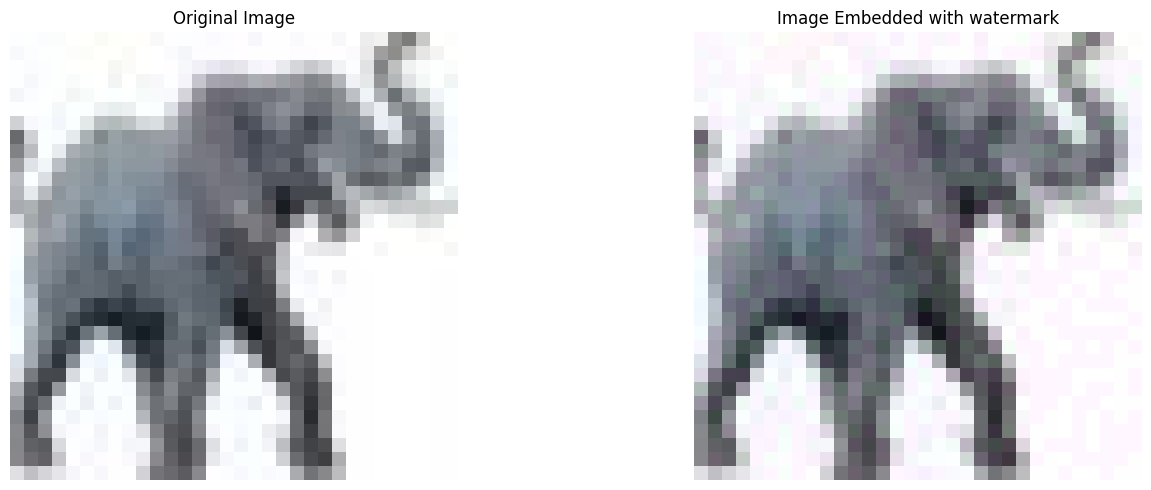

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(watermarked_img)
axes[1].set_title("Image Embedded with watermark")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [43]:
watermarked_img = read_image(watermarked_img_path)

Extracting the watermarking bits from the watermarked image

In [55]:
inputset = [(np.random.randint(0, 256)) for _ in range(100)]

In [56]:
decoder_compiler = fhe.Compiler(extract_bit_encrypted, {"val": "encrypted"})
decoder_circuit = decoder_compiler.compile(inputset, configuration=configuration, loop_parallelize=True)

In [57]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [58]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 19.743716752529146 minutes


In [26]:
def bin_str_to_bytes(bin_str):
    return bytes(int(bin_str[i:i+8], 2) for i in range(0, len(bin_str), 8)).decode('ISO-8859-1')

def decode_repeated_bits(bits, factor):

    def bit_count(bit):
        return sum([1 for i in range(bit.bit_length()) if bit & (1 << i)])

    result_bits = ''
    for i in range(0, len(bits), factor):
        bit_block = bits[i:min(i+factor, len(bits))]
        result_bits += '1' if sum(bit_block) > factor//2 else '0'

    return result_bits

In [59]:
decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
for i in range(watermark_len):
    inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]

In [24]:
def get_decoded_watermark(decoded_bits):
  decoded_bits = [1 if decoded_bits[i] else 0 for i in range(watermark_len)]
  inv_perm_watermark_bits = np.zeros(watermark_len, dtype=int)
  for i in range(watermark_len):
      inv_perm_watermark_bits[i] = decoded_bits[inv_permutation_map[i]]
  decoded_watermark_bits = decode_repeated_bits(inv_perm_watermark_bits, repetition_len)

  return bin_str_to_bytes(decoded_watermark_bits)

In [188]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama bounty     


We were able to decode the watermark message correctly using our 4-th bit embedding technique

## Performance on distortions/attacks on watermarked image

Robustness of watermarking technique is the good measure of the performance of the technique. In this section, we will discuss some of the major distortions and attacks on watermarked images

### JPEG Compression

In [19]:
def compress_image(img, quality=90):

    # Encode the image with JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded_img = cv2.imencode('.jpg', img, encode_param)

    # Decode the compressed image
    decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

    return decoded_img

In [20]:
watermarked_img = read_image(watermarked_img_path)
compressed_img = compress_image(watermarked_img, quality=90)
print(f"PSNR after compression = {cv2.PSNR(compressed_img, watermarked_img)}")

PSNR after compression = 33.18353606142344


The PSNR value after jpeg compression is within acceptable range indicating less degradation in quality

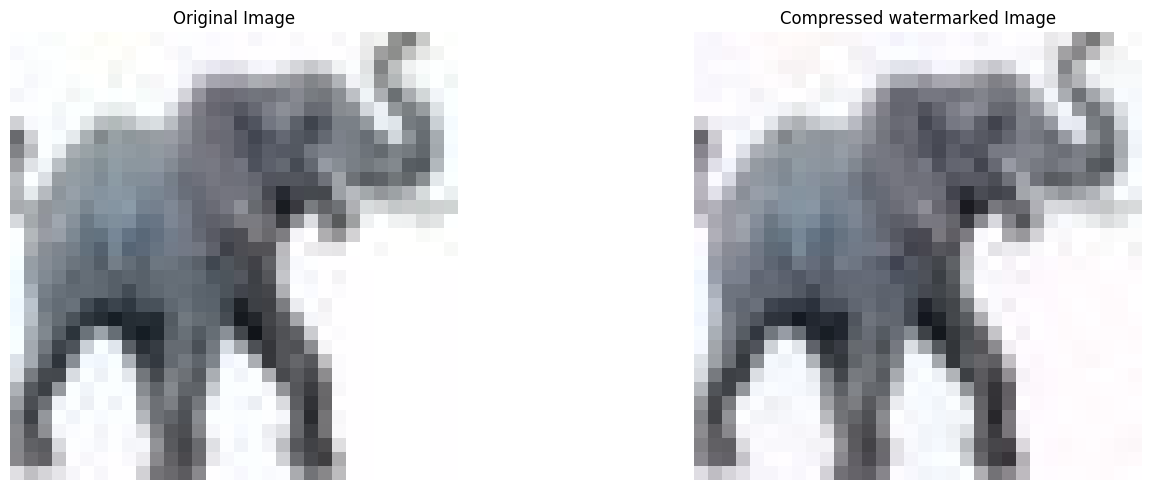

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(compressed_img)
axes[1].set_title("Compressed watermarked Image")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [28]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [ ]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 18.88556028665628 minutes


In [27]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = ÉBoiôÔs*<s[Rk¤ ]°!Å ÒMy÷Ôq¢


Our approach was not able to recover the watermark message after compressing the watermarked image. This didn't work because our scheme can tolerate upto N/2 changes in pixel value. However, after jpeg compression, most of the pixel values change making our technique useless against jpeg attack.

### Gaussian Noise

In [178]:
def add_gaussian_noise(image, mean=0, std=1):
    noise = np.abs(np.random.normal(mean, std, image.shape)).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image, noise

In [263]:
watermarked_img = read_image(watermarked_img_path)
noisy_watermarked_img, noise = add_gaussian_noise(watermarked_img)
print(f"PSNR after adding noise = {cv2.PSNR(noisy_watermarked_img, img)}")

PSNR after adding noise = 33.200027964119116


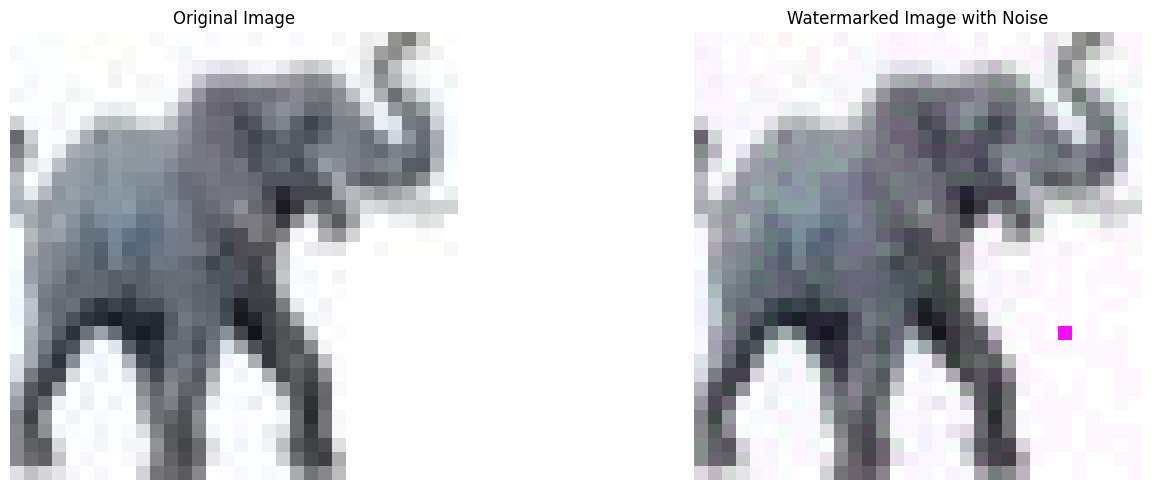

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(noisy_watermarked_img)
axes[1].set_title("Watermarked Image with Noise")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [ ]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [ ]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 20.02531191468679 minutes


In [195]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama b/unty     


Our approach was almost able to recover the watermark message(other than 'o' instead of '/' in 'bounty') after. This worked because the gaussian noise added was within certain range. If we add large gaussian noise, then we would not be able to recover the the watermarked image. However, in that case, the quality of the original image would also be almost degraded(PSNR would be very low).  

### Brightness And Contrast

In [253]:
watermarked_img = read_image(watermarked_img_path)
brightness = 1.5
contrast = 1.0
weighted_watermarked_img = cv2.addWeighted(watermarked_img, contrast, np.zeros(watermarked_img.shape, watermarked_img.dtype), 0, brightness)
print(f"PSNR after adding noise = {cv2.PSNR(weighted_watermarked_img, img)}")

PSNR after adding noise = 33.234047173253636


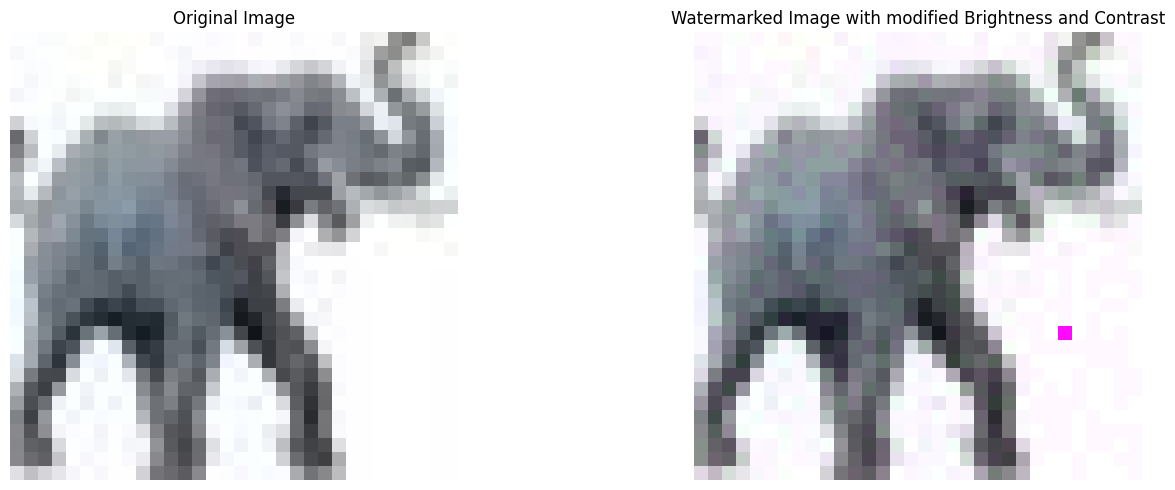

In [254]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(weighted_watermarked_img)
axes[1].set_title("Watermarked Image with modified Brightness and Contrast")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [29]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [ ]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 20.536803536986966 minutes


In [258]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = R${`vmz¡ár}¬ãov{áåa`r/wnôy 0


Our approach was not able to recover the watermark message after changing the contrast and brightness of the watermarked image. Similar to jpeg compression, changing brightness and contrast changes most of the pixel values making our technique again useless.

### Gaussian Blur

In [259]:
watermarked_img = read_image(watermarked_img_path)
blur_watermarked_img = cv2.GaussianBlur(watermarked_img, (1, 1), 0)
print(f"PSNR after gaussian blur = {cv2.PSNR(blur_watermarked_img, img)}")

PSNR after gaussian blur = 33.16546193858141


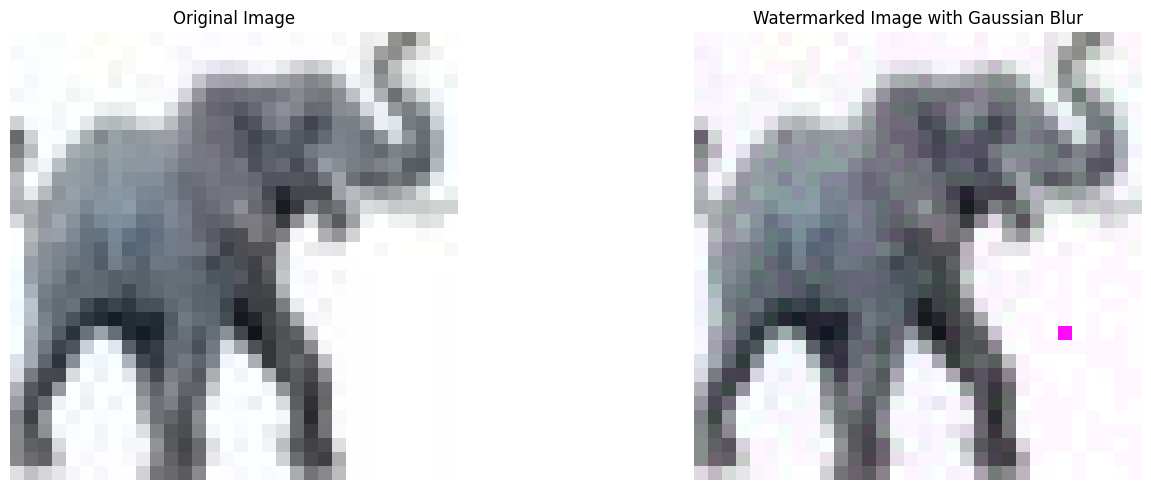

In [260]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(blur_watermarked_img)
axes[1].set_title("Watermarked Image with Gaussian Blur")
axes[1].axis('off')

plt.tight_layout(w_pad=3)

plt.show()

In [30]:
decoded_bits = []

start_time = time.time()
for i in range(l):
    print(f"Iteration : {i+1}")
    for j in range(b):
      decoded_bits.append(decoder_circuit.encrypt_run_decrypt(watermarked_img[i][j][index]))
end_time = time.time()

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32


In [ ]:
print(f"Total time taken = {(end_time-start_time)/60} minutes")

Total time taken = 19.93093495965919 minutes


In [262]:
print(f"Decoded watermark = {get_decoded_watermark(decoded_bits)}")

Decoded watermark = A watermark for zama bounty     


Our approach was able to recover the original watermark after adding gaussian blur to the watermarked image. Similar to noise addition, if we add large gaussian blur to our images we would not be able to recover the watermark. However, in that case the watermarked image would be completely disorted.